# Question 2

Problem objective: This problem measures the candidate’s competency in problem-solving, data processing, optimization and machine learning algorithms, analysis, and visualization.

Data overview:

-	Download the synthetic survey dataset available at: https://microdata.worldbank.org/index.php/catalog/5906
-	This survey dataset provides data at the household and individual levels.
-	The household-level file contains variables related to household consumption: exp_01 to exp_12, tot_exp, tot_food, share_food, and pc_exp.
-	The file also contains the expenditure quintiles: quint_nat, quint_urb, quint_rur.


Problem description:

-	Implement a clustering model that takes an arbitrary number of variables, OTHER than the expenditure or quintile variables, and produces 5 clusters.
-	Identify the combination of at most 10 variables that result in 5 clusters with the highest alignment to the national quintile (quint_nat) groupings.
o	NOTE: The highest possible alignment is achieved when each cluster exclusively contains individuals classified under the same national quintile group. The lowest possible alignment is when the cluster has a uniform distribution of individuals across the national quintile group.
-	Produce a visualization showing the correlations of the optimal variables identified with respect to the expenditure variables. 



## Load Libraries

In [31]:
import numpy as np
import pandas as pd
import os
import requests
import zipfile
from itertools import combinations
from sklearn.feature_selection import mutual_info_classif
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import warnings

# Ignore deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


## Download Data

In [2]:
# URL of the ZIP file to download
url = 'https://microdata.worldbank.org/index.php/catalog/5906/download/62501'

# Local path to save the downloaded ZIP file
zip_file_path = 'downloaded_data.zip'

# Directory to extract the contents of the ZIP file
extract_to_dir = 'data'
os.makedirs(extract_to_dir, exist_ok=True)

# Download the ZIP file
print("Downloading ZIP file...")
response = requests.get(url)
with open(zip_file_path, 'wb') as zip_file:
    zip_file.write(response.content)
print("Download completed.")

# Extract the ZIP file
print("Extracting ZIP file...")
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_dir)
print(f"Extraction completed. Files are extracted to '{extract_to_dir}'")

# Optionally, remove the downloaded ZIP file after extraction
os.remove(zip_file_path)
print("Downloaded ZIP file removed.")


Download completed.
Extracting ZIP file...
Extraction completed. Files are extracted to 'data'
Downloaded ZIP file removed.


In [3]:
# Get the current directory path
current_directory = os.getcwd()

# Append '/data/' to the current directory path
data_directory = os.path.join(current_directory, 'data')

print(data_directory)


c:\OPSSR\data


In [4]:
# Set the path to the data folder
data_folder = data_directory

# Load the household-level data
hld_file_path = f"{data_folder}/WLD_2023_SYNTH-SVY-HLD-EN_v01_M.dta"
hld_df = pd.read_stata(hld_file_path)

# Load the individual-level data
ind_file_path = f"{data_folder}/WLD_2023_SYNTH-SVY-IND-EN_v01_M.dta"
ind_df = pd.read_stata(ind_file_path)


In [44]:
hld_df.head()

,hid,geo1,geo2,ea,urbrur,hhsize,statocc,rooms,bedrooms,floor,...,exp_12,tot_exp,tot_food,share_food,pc_exp,quint_nat,quint_urb,quint_rur,hhweight,popweight
0,00a191396a2,geo_01,geo_01_01,11066,Urban,1,Owned,1,1,Cement/concrete,...,326,5044,1279,0.254,5044.0,richest,rich,NaN,322.972201,322.972201
1,0111c7fa67c,geo_01,geo_01_01,11066,Urban,1,Rented,1,0,Cement/concrete,...,234,4652,1755,0.377,4652.0,richest,rich,NaN,322.972201,322.972201
2,01410d9c60d,geo_01,geo_01_01,11087,Urban,2,Owned,4,1,Cement/concrete,...,836,9957,1722,0.173,4978.5,richest,rich,NaN,256.192235,512.384469
3,015ff82b55c,geo_01,geo_01_01,11094,Urban,2,Owned,1,1,Cement/concrete,...,928,11533,3700,0.321,5766.5,richest,richest,NaN,268.334047,536.668093
4,01c39d3df0d,geo_01,geo_01_01,11094,Urban,1,Rented,3,2,Other,...,689,14549,1492,0.103,14549.0,richest,richest,NaN,268.334047,268.334047


In [45]:
ind_df.head()

,hid,idno,relation,sex,age,age_month,marstat,religion,school_attend,educ_attain,...,migrate_recent,disability,blind,deaf,mental,ch_weight,ch_height,children_born,children_surv,births_12m
0,00a191396a2,1,Head,Male,31,NaN,Single/never married,Religion E,Yes,Secondary,...,NIU (not in universe),No disability,No,No,No,NaN,NaN,NaN,NaN,NaN
1,0111c7fa67c,1,Head,Female,54,NaN,Married/in union,Religion E,"No, never attended",Less than primary,...,Different major administrative unit,No disability,No,No,No,NaN,NaN,1.0,1.0,0.0
2,01410d9c60d,1,Head,Male,32,NaN,Married/in union,Religion E,Yes,Secondary,...,"Same major, same minor administrative u",No disability,No,No,No,NaN,NaN,NaN,NaN,NaN
3,01410d9c60d,2,Other relative,Female,55,NaN,Widowed,Religion E,"No, not specified if ever attended",Less than primary,...,"Same major, same minor administrative u",No disability,No,No,No,NaN,NaN,NaN,NaN,NaN
4,015ff82b55c,1,Head,Male,54,NaN,Married/in union,Other,"No, not specified if ever attended",Less than primary,...,"Same major, different minor administrat",No disability,No,No,No,NaN,NaN,NaN,NaN,NaN


### Merge two datasets

In [5]:
# check the shape of the data
len(hld_df.hid.unique()), len(ind_df.hid.unique())

(8000, 8000)

In [6]:
# Get common columns
common_cols = list(set(hld_df.columns) & set(ind_df.columns))
common_cols

['hid', 'hhweight']

In [7]:
ind_df.drop(columns=['hhweight'], inplace=True)
merged_df = pd.merge(hld_df, ind_df, on='hid', how='inner')
merged_df.head()

,hid,geo1,geo2,ea,urbrur,hhsize,statocc,rooms,bedrooms,floor,...,migrate_recent,disability,blind,deaf,mental,ch_weight,ch_height,children_born,children_surv,births_12m
0,00a191396a2,geo_01,geo_01_01,11066,Urban,1,Owned,1,1,Cement/concrete,...,NIU (not in universe),No disability,No,No,No,NaN,NaN,NaN,NaN,NaN
1,0111c7fa67c,geo_01,geo_01_01,11066,Urban,1,Rented,1,0,Cement/concrete,...,Different major administrative unit,No disability,No,No,No,NaN,NaN,1.0,1.0,0.0
2,01410d9c60d,geo_01,geo_01_01,11087,Urban,2,Owned,4,1,Cement/concrete,...,"Same major, same minor administrative u",No disability,No,No,No,NaN,NaN,NaN,NaN,NaN
3,01410d9c60d,geo_01,geo_01_01,11087,Urban,2,Owned,4,1,Cement/concrete,...,"Same major, same minor administrative u",No disability,No,No,No,NaN,NaN,NaN,NaN,NaN
4,015ff82b55c,geo_01,geo_01_01,11094,Urban,2,Owned,1,1,Cement/concrete,...,"Same major, different minor administrat",No disability,No,No,No,NaN,NaN,NaN,NaN,NaN


## Data Processing

### Handle Missing Values

In [10]:
merged_df.shape

(32396, 74)

In [8]:
def check_missing_data(data):
    # Calculate missing values per column
    missing_values_count = data.isnull().sum()

    # Calculate percentage of missing values per column
    missing_values_percentage = 100 * missing_values_count / len(data)

    # Create a table with results
    missing_data_table = pd.concat([missing_values_count, missing_values_percentage], axis=1)
    missing_data_table.rename(columns={0: 'Missing Values', 1: '% of Total Values'}, inplace=True)

    # Sort by percentage of missing descending
    missing_data_table.sort_values('% of Total Values', ascending=False, inplace=True)

    return missing_data_table

missing_data_table = check_missing_data(merged_df)
missing_data_table

,Missing Values,% of Total Values
ch_height,29231,90.230275
ch_weight,29231,90.230275
age_month,29231,90.230275
children_surv,24681,76.185332
births_12m,21076,65.057414
...,...,...
tv,0,0.000000
refrigerator,0,0.000000
motorcycle,0,0.000000
bicycle,0,0.000000


In [9]:
missing_data_table[missing_data_table['% of Total Values'] > 0]

,Missing Values,% of Total Values
ch_height,29231,90.230275
ch_weight,29231,90.230275
age_month,29231,90.230275
children_surv,24681,76.185332
births_12m,21076,65.057414
children_born,20773,64.122114
quint_rur,16874,52.086677
quint_urb,15522,47.913323
yrs_school,2542,7.846648
deaths_12m,255,0.787134


In [10]:
merged_df['yrs_school'].value_counts()

0.0     11314
9.0      1803
8.0      1583
6.0      1553
4.0      1525
3.0      1430
1.0      1367
12.0     1363
7.0      1343
2.0      1204
5.0      1152
10.0      973
11.0      884
13.0      863
16.0      443
14.0      282
15.0      276
18.0      265
17.0      231
Name: yrs_school, dtype: int64

In [11]:
merged_df['deaths_12m'].value_counts()

0.0    30221
1.0     1543
2.0      207
3.0       76
5.0       34
7.0       32
4.0       28
Name: deaths_12m, dtype: int64

In [12]:
# drop columns with more than 40% missing values
merged_df.drop(columns=missing_data_table[missing_data_table['% of Total Values'] > 40].index, inplace=True)

# impute missing values in yrs_school and deaths_12m columns
imputer_yrs_school = SimpleImputer(strategy='mean')  
imputer_deaths_12m = SimpleImputer(strategy='most_frequent') 

# Apply the imputer to the 'yrs_school' column
merged_df['yrs_school'] = imputer_yrs_school.fit_transform(merged_df[['yrs_school']])

# Apply the imputer to the 'deaths_12m' column
merged_df['deaths_12m'] = imputer_deaths_12m.fit_transform(merged_df[['deaths_12m']])

### Feature Engineer

In [21]:
# check number of duplicate columns
merged_df.duplicated().sum()

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32396 entries, 0 to 32395
Data columns (total 66 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   hid             32396 non-null  object  
 1   geo1            32396 non-null  category
 2   geo2            32396 non-null  category
 3   ea              32396 non-null  int32   
 4   urbrur          32396 non-null  category
 5   hhsize          32396 non-null  int8    
 6   statocc         32396 non-null  category
 7   rooms           32396 non-null  int8    
 8   bedrooms        32396 non-null  int8    
 9   floor           32396 non-null  category
 10  walls           32396 non-null  category
 11  roof            32396 non-null  category
 12  water           32396 non-null  category
 13  piped_water     32396 non-null  category
 14  toilet          32396 non-null  category
 15  flush_toilet    32396 non-null  category
 16  electricity     32396 non-null  category
 17  cook_fuel   

In [22]:
#  Identify feature columns (excluding expenditure and quintile variables)
feature_cols = [col for col in merged_df.columns if col not in ['exp_01', 'exp_02', 'exp_03', 'exp_04',
                                                                'exp_05', 'exp_06', 'exp_07', 'exp_08',
                                                                'exp_09', 'exp_10', 'exp_11', 'exp_12', 
                                                                'tot_exp', 'tot_food', 'share_food', 'pc_exp', 
                                                                'quint_nat', 'quint_urb', 'quint_rur', 'hid', 'hhweight']]

# Identify categorical and numerical columns from the feature columns
categorical_cols = merged_df[feature_cols].select_dtypes(include=['category', 'object']).columns.tolist()
numerical_cols = merged_df[feature_cols].select_dtypes(exclude=['category', 'object']).columns.tolist()

In [24]:
# Initialize OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Encode categorical features and convert to DataFrame with appropriate column names
encoded_features = encoder.fit_transform(merged_df[categorical_cols])
encoded_features_df = pd.DataFrame(encoded_features, columns=[f"enc_{col}" for col in encoder.get_feature_names_out(categorical_cols)])
encoded_features_df.index = merged_df.index  # Ensure the index aligns with the original DataFrame

# Add encoded features to the original DataFrame
merged_df = pd.concat([merged_df, encoded_features_df], axis=1)


C:\Users\chiaj\AppData\Roaming\Python\Python38\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [25]:
# Initialize StandardScaler
scaler = StandardScaler()

# Scale numerical features and convert to DataFrame with appropriate column names
scaled_numerical_features = scaler.fit_transform(merged_df[numerical_cols])
scaled_numerical_features_df = pd.DataFrame(scaled_numerical_features, columns=[f"scaled_{col}" for col in numerical_cols])
scaled_numerical_features_df.index = merged_df.index  # Ensure the index aligns with the original DataFrame

# Add scaled numerical features to the original DataFrame
merged_df = pd.concat([merged_df, scaled_numerical_features_df], axis=1)

In [26]:
merged_df.head()

,hid,geo1,geo2,ea,urbrur,hhsize,statocc,rooms,bedrooms,floor,...,enc_mental_Yes,scaled_ea,scaled_hhsize,scaled_rooms,scaled_bedrooms,scaled_deaths_12m,scaled_popweight,scaled_idno,scaled_age,scaled_yrs_school
0,00a191396a2,geo_01,geo_01_01,11066,Urban,1,Owned,1,1,Cement/concrete,...,0.0,-1.482237,-1.686079,-1.171370,-0.851435,-0.198074,-1.527196,-1.019547,0.142217,2.184318
1,0111c7fa67c,geo_01,geo_01_01,11066,Urban,1,Rented,1,0,Cement/concrete,...,0.0,-1.482237,-1.686079,-1.171370,-1.920754,-0.198074,-1.527196,-1.019547,1.284395,-0.977430
2,01410d9c60d,geo_01,geo_01_01,11087,Urban,2,Owned,4,1,Cement/concrete,...,0.0,-1.481546,-1.282230,0.679526,-0.851435,-0.198074,-1.300645,-1.019547,0.191877,2.184318
3,01410d9c60d,geo_01,geo_01_01,11087,Urban,2,Owned,4,1,Cement/concrete,...,0.0,-1.481546,-1.282230,0.679526,-0.851435,-0.198074,-1.300645,-0.531144,1.334055,-0.977430
4,015ff82b55c,geo_01,geo_01_01,11094,Urban,2,Owned,1,1,Cement/concrete,...,0.0,-1.481316,-1.282230,-1.171370,-0.851435,-0.198074,-1.271601,-1.019547,1.284395,-0.977430


In [27]:
encoded_and_scaled_features = [col for col in merged_df.columns if 'enc_' in col or 'scaled_' in col]
merged_df_encoded_scaled = merged_df[encoded_and_scaled_features]
# add hid, quint_nat variables to the encoded and scaled features
merged_df_encoded_scaled['hid'] = merged_df['hid']
merged_df_encoded_scaled['quint_nat'] = merged_df['quint_nat']

C:\Users\chiaj\AppData\Local\Temp\ipykernel_28812\347955992.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_encoded_scaled['hid'] = merged_df['hid']
C:\Users\chiaj\AppData\Local\Temp\ipykernel_28812\347955992.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_encoded_scaled['quint_nat'] = merged_df['quint_nat']


## Randomly Select 100 Variables

Randomly select 100 variables from the encoded and scaled dataset (merged_df_encoded_scaled), also ensured to include hid (household ID) and quint_nat (national quintile groupings) variables.

In [28]:
# select random 100 variables from the encoded and scaled features
df_100 = merged_df_encoded_scaled.sample(n=100, axis=1, random_state=1)
df_100['hid'] = merged_df['hid']
df_100['quint_nat'] = merged_df['quint_nat']
df_100

,enc_geo2_geo_10_08,quint_nat,"enc_industry_Electricity, gas, water and waste manag",enc_toilet_Pit latrine without slab/open pit,enc_roof_Metal,enc_migrate_recent_Abroad,enc_geo2_geo_09_07,enc_act_status_Unemployed,enc_educ_attain_Primary,enc_geo1_geo_05,...,enc_blind_Yes,enc_toilet_Other,enc_geo2_geo_06_02,enc_geo2_geo_01_08,enc_geo1_geo_06,enc_literacy_Yes,enc_educ_attain_Less than primary,enc_geo2_geo_07_04,enc_occupation_Plant and machine operators and assembl,enc_geo2_geo_10_07
0,0.0,richest,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,richest,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,0.0,richest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,richest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0.0,richest,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32391,0.0,rich,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
32392,0.0,rich,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
32393,0.0,rich,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
32394,0.0,rich,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [29]:
X = df_100.drop(['hid', 'quint_nat'], axis=1)  # Features
y = df_100['quint_nat']  # Target

# Initialize an empty list to hold the selected features
best_features = []
best_score = 0


## Select Optimal Feature Combination

Iteratively select up to 10 top features based on mutual information scores and perform K-Means clustering with these features to create 5 clusters. For each feature combination, I calculated the homogeneity score to evaluate how well the clustering aligns with national quintile groupings.

The optimal set of features is identified by achieving the highest homogeneity score, which suggests that these features are highly effective in predicting the national quintile groupings through clustering. The selection process involved identifying the feature combination that resulted in the maximum homogeneity score, marking it as the most suitable choice.

In [ ]:
# Calculate mutual information between each feature and the target
mi_scores = mutual_info_classif(X, y)

# Sort the features based on their mutual information scores
sorted_features = X.columns[np.argsort(mi_scores)[::-1]]

In [32]:
# Use tqdm to track progress
for i in tqdm(range(1, 11)):
    # Select the top i features
    selected_features = sorted_features[:i]

    # Select features based on the list of selected features
    X_subset = X.loc[:, selected_features]

    # Perform K-Means clustering
    kmeans = KMeans(n_clusters=5, random_state=42).fit(X_subset)

    # Calculate homogeneity score
    score = homogeneity_score(y, kmeans.labels_)

    # Keep track of the best combination of features
    if score > best_score:
        best_score = score
        best_features = selected_features

print(f"Best combination of features: {best_features}")
print(f"Best homogeneity score: {best_score}")


  0%|          | 0/10 [00:00<?, ?it/s]C:\Users\chiaj\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\chiaj\AppData\Local\Temp\ipykernel_28812\1070949758.py:16: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=5, random_state=42).fit(X_subset)
 10%|█         | 1/10 [00:00<00:01,  5.09it/s]C:\Users\chiaj\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\chiaj\AppData\Local\Temp\ipykernel_28812\1070949758.py:16: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (

Best combination of features: Index(['enc_tv_No', 'enc_tv_Yes', 'enc_toilet_No facility/bush/field',
       'enc_urbrur_Rural'],
      dtype='object')
Best homogeneity score: 0.15854085070073495


## Correlation Visualization

Here is a heatmap using seaborn to visualize the correlation matrix, applying a mask for the upper triangle to avoid redundancy in visualization.

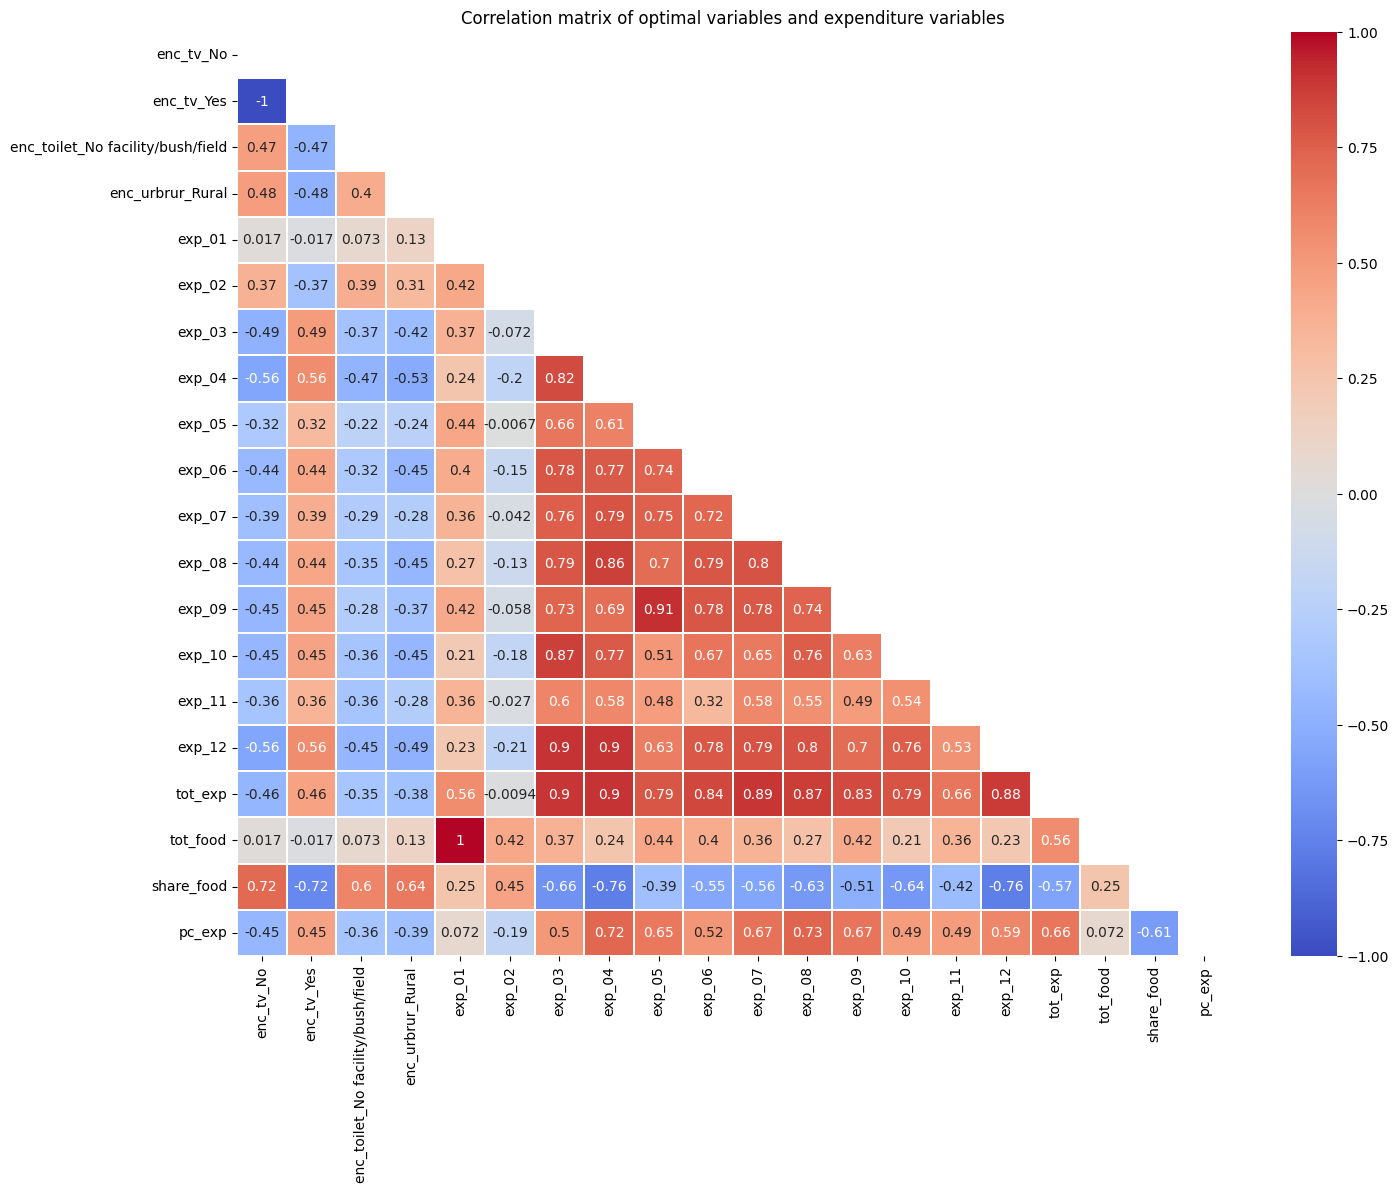

In [35]:
# Select expenditure variables
expenditure_cols = ['exp_01', 'exp_02', 'exp_03', 'exp_04', 'exp_05', 'exp_06', 'exp_07', 'exp_08',
                    'exp_09', 'exp_10', 'exp_11', 'exp_12', 'tot_exp', 'tot_food', 'share_food', 'pc_exp']

# Select the optimal variables and the expenditure variables
optimal_vars = merged_df[['hid'] + best_features.tolist()]
expenditure_vars = merged_df[['hid'] + expenditure_cols]

# Merge the optimal variables and the expenditure variables
merged_vars = pd.merge(optimal_vars, expenditure_vars, on='hid')

# Calculate the correlation matrix
corr_matrix = merged_vars.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Create a heatmap using seaborn
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.05, mask=mask)
plt.title('Correlation matrix of optimal variables and expenditure variables')
plt.show()


The heatmap of correlations between optimal features and expenditure variables provides insights into how these selected features relate to various expenditure metrics. This can reveal patterns or dependencies that might be useful for further analysis or predictive modeling.

## Conclusion

The analysis focused on identifying a set of features that best predict national quintile groupings through clustering. The optimal feature combination was found to be a mix of variables related to television ownership ('enc_tv_No', 'enc_tv_Yes'), toilet facilities ('enc_toilet_No facility/bush/field'), and urban or rural dwelling status ('enc_urbrur_Rural'). This selection was based on achieving the highest homogeneity score of 0.15854085070073495 among all tested combinations.

This score, while modest, indicates some level of alignment between the clusters formed using these features and the actual national quintile groupings. The presence of both television ownership and type of toilet facilities as significant predictors suggests that access to basic amenities and living conditions are indicative of economic status within the national context. The inclusion of urban or rural dwelling status further emphasizes the impact of geographical location on economic classification.

These findings highlight the complex interplay between various socio-economic factors and their collective ability to predict economic standing within a nation. The identified features can serve as a basis for more detailed analysis on socio-economic stratification and aid in the development of targeted interventions for economic development.